In [2]:
using CSV, DataFrames, Plots, DelimitedFiles, Distances, CategoricalArrays, StatsPlots, LinearAlgebra, MLJ, StatsBase, ROC

# Q5.(a) ROC plot

In [3]:
df = DataFrame(c = [0.95,0.85,0.8,0.7,0.55,0.45,0.4,0.3,0.2,0.1],
                y = [1,1,0,1,1,0,1,1,0,0])
TP = 0
FP = 0
last_TP = 0

for i in 1:10 
    if i>1 && df.y[i] == 0 && TP > last_TP
      if df.c[i] != df.c[i-1] 
        FPR = FP /4
        TPR = TP /6
        println(df.c[i])
        println([FPR,TPR])
      end
    end
    if df.y[i] == 1
      TP = TP+1
    else
      FP = FP+1
    end
    end
FPR = FP /4
TPR = TP /6
print([FPR,TPR])

0.8


[0.0, 0.3333333333333333]
0.45
[0.25, 0.6666666666666666]
0.2
[0.5, 1.0]
0.1
[0.75, 1.0]
[1.0, 1.0]

In [4]:
ROC_q5 = DataFrame(FPR=[0,0,0.25,0.5,0.75,1],TPR=[0,1/3,2/3,1,1,1]);

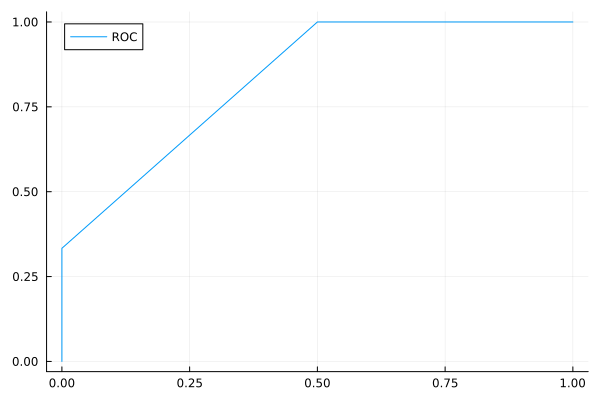

In [5]:
plot(
    ROC_q5.FPR,
    ROC_q5.TPR,
    label = "ROC",
    markersize = 10
)

# Q2.1

In [6]:
D2z = DataFrame(readdlm("./data/D2z.txt", ' ', Float32, '\n'), :auto);
rename!(D2z,[:x1,:x2,:y]);
testD2z = DataFrame(x1 = repeat([-2:0.1:2;], outer = 41),
                    x2 = repeat([-2:0.1:2;], inner = 41),
                    y =  repeat([-1],1681));
dist_matrix = pairwise(Euclidean(), Matrix(D2z[!,1:2]), Matrix(testD2z[!,1:2]), dims=1);                    

In [7]:
int(x) = floor(Int, x)
for i in 1:1681 
    testD2z.y[i] = D2z.y[findmin(dist_matrix[:,i])[2]]  
end
D2z.y = categorical(map(Int,D2z.y));
testD2z.y = categorical(testD2z.y);

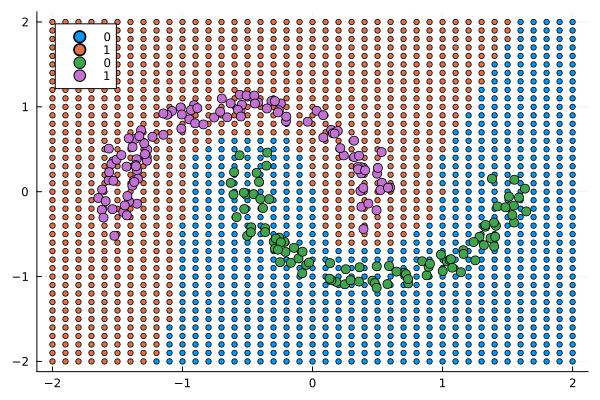

In [23]:
@df testD2z scatter(:x1, :x2, group = :y, markersize = 3, legend = :topleft)
@df D2z scatter!(:x1, :x2, group = :y, markersize = 5, legend = :topleft)

# Q2.2

In [9]:
emails = DataFrame(CSV.File("./data/emails.csv"));

In [10]:
emails_test_1 = emails[1:1000,:];
emails_test_2 = emails[1001:2000,:];
emails_test_3 = emails[2001:3000,:];
emails_test_4 = emails[3001:4000,:];
emails_test_5 = emails[4001:5000,:];

emails_train_1 = emails[1001:5000,:];
emails_train_2 = vcat(emails[1:1000,:],emails[2001:5000,:]);
emails_train_3 = vcat(emails[1:2000,:],emails[3001:5000,:]);
emails_train_4 = vcat(emails[1:3000,:],emails[4001:5000,:]);
emails_train_5 = emails[1:4000,:];

emails_test = [emails_test_1,emails_test_2,emails_test_3,emails_test_4,emails_test_5];
emails_train = [emails_train_1,emails_train_2,emails_train_3,emails_train_4,emails_train_5];


In [11]:
dist_matrix_1 = pairwise(Euclidean(), Matrix(emails_train[1][!,2:3001]), Matrix(emails_test[1][!,2:3001]), dims=1);
dist_matrix_2 = pairwise(Euclidean(), Matrix(emails_train[2][!,2:3001]), Matrix(emails_test[2][!,2:3001]), dims=1);
dist_matrix_3 = pairwise(Euclidean(), Matrix(emails_train[3][!,2:3001]), Matrix(emails_test[3][!,2:3001]), dims=1);
dist_matrix_4 = pairwise(Euclidean(), Matrix(emails_train[4][!,2:3001]), Matrix(emails_test[4][!,2:3001]), dims=1);
dist_matrix_5 = pairwise(Euclidean(), Matrix(emails_train[5][!,2:3001]), Matrix(emails_test[5][!,2:3001]), dims=1);
dist_matrix = [dist_matrix_1,dist_matrix_2,dist_matrix_3,dist_matrix_4,dist_matrix_5];


In [12]:
for i in 1:5
    emails_test[i].knn_1 = zeros(Int,1000) 
    for j in 1:1000 
       emails_test[i].knn_1[j] = emails_train[i][:,3002][findmin(dist_matrix[i][:,j])[2]]  
    end
end

In [13]:
for i in 1:5
    emails_test[i][:,3002] = categorical(map(Int,emails_test[i][:,3002]),ordered=true);
    emails_test[i].knn_1 = categorical(emails_test[i].knn_1,ordered=true);
    println([Accuracy()(emails_test[i][:,3002], emails_test[i].knn_1),
    Recall()(emails_test[i][:,3002], emails_test[i].knn_1),
    Precision()(emails_test[i][:,3002], emails_test[i].knn_1)])
end

[0.825, 0.6544943820224719, 0.8175438596491228]
[0.853, 0.6857142857142857, 0.8664259927797834]
[0.862, 0.7212121212121212, 0.8380281690140845]
[0.851, 0.7164179104477612, 0.8163265306122449]
[0.775, 0.6057441253263708, 0.7581699346405228]


# Q2.3 $\eta = 0.5$

In [14]:
η = 0.5
Threads.@threads for i in 1:5
    x = Matrix(emails_train[i][:,2:3001])
    y = Vector(emails_train[i][:,3002])
    θ = zeros(Int,3000)
    ΔL = 1
    w = 1
    
    while ΔL > 1e-4 && w < 2000
      σ = x * θ  
      ŷ = 1 ./ (1 .+ exp.(-σ))
      ∂L = transpose(x) * (ŷ - y)
      ΔL = abs(norm(θ) - norm(θ - η /4000 .* ∂L))
      θ = θ - η / 4000 .* ∂L
      w = w + 1
      #  dtheta <- norm(dy)
    end
    emails_test[i].logistic = ifelse.(1 ./ (1 .+ exp.(-Matrix(emails_test[i][:,2:3001]) * θ)) .> 0.5,1,0)
end
  

In [15]:
for i in 1:5
    emails_test[i][:,3002] = categorical(map(Int,emails_test[i][:,3002]),ordered=true);
    emails_test[i].logistic = categorical(emails_test[i].logistic,ordered=true);
    println([Accuracy()(emails_test[i][:,3002], emails_test[i].logistic),
    Recall()(emails_test[i][:,3002], emails_test[i].logistic),
    Precision()(emails_test[i][:,3002], emails_test[i].logistic)])
end

[0.922, 0.9123505976095617, 0.8035087719298246]
[0.919, 0.9117647058823529, 0.7833935018050542]
[0.905, 0.902127659574468, 0.7464788732394366]
[0.929, 0.8754208754208754, 0.8843537414965986]
[0.884, 0.7777777777777778, 0.869281045751634]


# Q2.4

In [16]:
for i in 1:5
    emails_test[i].knn_3 = zeros(Int,1000) 
    emails_test[i].knn_5 = zeros(Int,1000)
    emails_test[i].knn_7 = zeros(Int,1000) 
    emails_test[i].knn_9 = zeros(Int,1000)  
    for j in 1:1000 
        emails_test[i].knn_3[j] = mode(emails_train[i][:,3002][partialsortperm(dist_matrix[i][:,j],1:3)])
        emails_test[i].knn_5[j] = mode(emails_train[i][:,3002][partialsortperm(dist_matrix[i][:,j],1:5)])
        emails_test[i].knn_7[j] = mode(emails_train[i][:,3002][partialsortperm(dist_matrix[i][:,j],1:7)])
        emails_test[i].knn_9[j] = mode(emails_train[i][:,3002][partialsortperm(dist_matrix[i][:,j],1:9)])  
    end
end

In [17]:
for j in [3003,3005,3006,3007,3008]
    ave = 0
    for i in 1:5
        ave = ave + Accuracy()(emails_test[i][:,3002], emails_test[i][:,j])
    end
    println(ave/5)
end

0.8332


0.8423999999999999
0.8417999999999999
0.8454
0.8458


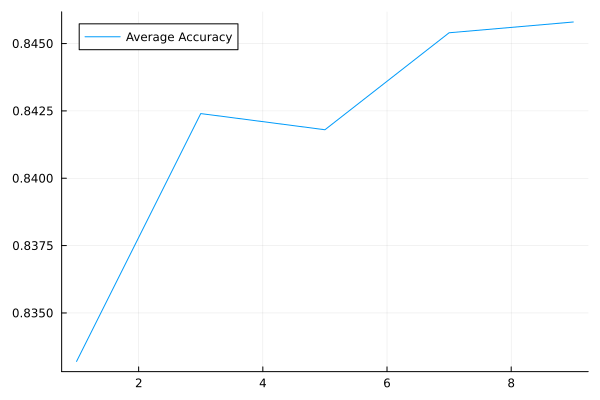

In [18]:
ave_plot = DataFrame(accuracy = [0.8332,0.8424,0.8418,0.8454,0.8458],k = [1,3,5,7,9])
plot(
    ave_plot.k,
    ave_plot.accuracy,
    label = "Average Accuracy",
    markersize = 10
)

# Q2.5

In [19]:
train = emails[1:4000,:]
test = emails[4001:5000,:]
dist_matrix_q5 = pairwise(Euclidean(), Matrix(train[!,2:3001]), Matrix(test[!,2:3001]), dims=1);

test.knn_5 = zeros(Float16,1000)
for j in 1:1000 
    test.knn_5[j] = mean(train[:,3002][partialsortperm(dist_matrix_q5[:,j],1:5)])
end

In [20]:
η = 10
x = Matrix(train[:,2:3001])
y = Vector(train[:,3002])
θ = zeros(Float16,3000)
ΔL = 1
w = 1
while ΔL > 1e-4 && w < 2000
  σ = x * θ  
  ŷ = 1 ./ (1 .+ exp.(-σ))
  ∂L = transpose(x) * (ŷ - y)
  ΔL = abs(norm(θ) - norm(θ - η /4000 .* ∂L))
  θ = θ - η / 4000 .* ∂L
  w = w + 1
  #  dtheta <- norm(dy)
end
test.logistic = 1 ./ (1 .+ exp.(-Matrix(test[:,2:3001]) * θ));

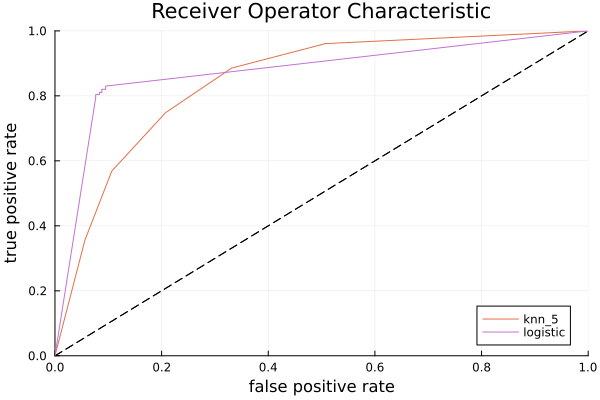

In [21]:
r = ROC.roc(test.knn_5, test[:,3002]);
l = ROC.roc(test.logistic, test[:,3002]);
plot(r,label = "knn_5")
plot!(l,label = "logistic")

In [22]:
[ROC.AUC(r),ROC.AUC(l)]

2-element Vector{Float64}:
 0.8464146465502627
 0.8735402422256127